In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 
import h5py
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

/home/dbj/anaconda3/envs/cosmos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import time
from memory_profiler import memory_usage
import torch

In [3]:
device_idx = 0

def measure_resources(func):
    def wrapper(*args, **kwargs):
        result = None
        
        start_time = time.time()
        mem, result = memory_usage(
            (func, args, kwargs), 
            max_usage=True, 
            retval=True
        )
        
        mem_usage_gb = mem / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        
        if torch.cuda.is_available():
            try:
                device = torch.device(f"cuda:{device_idx}")
                allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
                cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
            except:
                allocated = cached = 0
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage_gb:.2f} GB")
        print(f"GPU memory allocated: {allocated:.4f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")
        
        return result

    return wrapper

In [4]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset16_Simulation4/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

In [5]:
@measure_resources
def run_pipeline():
    cosmos_comb = cosmos.Cosmos(adata1=adata_omics1,adata2=adata_omics2)
    cosmos_comb.preprocessing_data(n_neighbors = 16)
    cosmos_comb.train(spatial_regularization_strength=0.01, z_dim=50, 
             lr=1e-3, wnn_epoch = 500, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
             random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)
    weights = cosmos_comb.weights
    df_embedding = pd.DataFrame(cosmos_comb.embedding)
    return df_embedding
df_embedding=run_pipeline()

Epoch 1/1000, Loss: 1.3925145864486694
Epoch 11/1000, Loss: 1.0122613906860352
Epoch 21/1000, Loss: 0.6187463402748108
Epoch 31/1000, Loss: 0.2991321086883545
Epoch 41/1000, Loss: 0.15092308819293976
Epoch 51/1000, Loss: 0.12315481901168823
Epoch 61/1000, Loss: 0.06390506029129028
Epoch 71/1000, Loss: 0.053915612399578094
Epoch 81/1000, Loss: 0.055256761610507965
Epoch 91/1000, Loss: 0.03442972153425217
Epoch 101/1000, Loss: 0.02544998563826084
Epoch 111/1000, Loss: 0.026783498004078865
Epoch 121/1000, Loss: 0.03597408905625343
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 1296 0.00 seconds elapsed
Selecting top K neighbors
Epoch 131/1000, Loss: 0.01566248945891857
Epoch 141/1000, Loss: 0.013362773694097996
Epoch 151/1000, Loss: 0.012995167635381222
Epoch 161/1000, Loss: 0.018945157527923584
Epoch 171/1000, Loss: 0.010707316920161247
Epoch 181/100

In [6]:
adata_omics1.obsm['COSMOS']=df_embedding.to_numpy()

In [7]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata_omics1.obsm['COSMOS'])
adata_omics1.obs['COSMOS']=labels.astype(str)

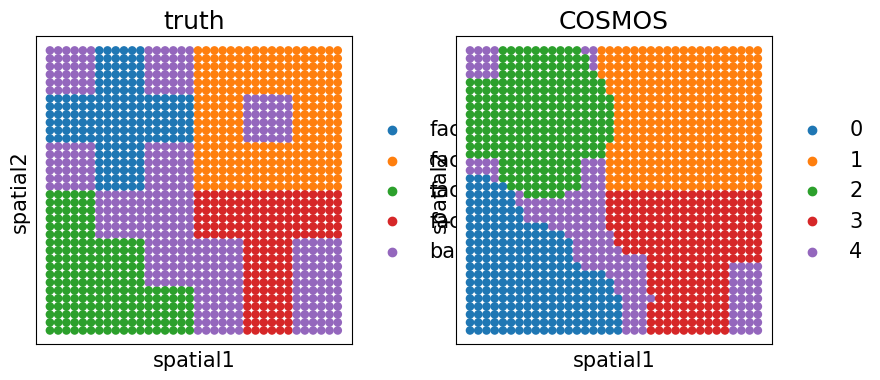

In [8]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata_omics1,basis='spatial',color=['truth','COSMOS'],size=155)

In [9]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['COSMOS'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.579131735735447
NMI: 0.7044064704693535
AMI: 0.7032326768978018
FMI: 0.6707385855393063
V-Measure: 0.7044064704693533
Homogeneity: 0.7143423767705641


In [10]:
adata_omics1.write_h5ad('/home/dbj/SpaLP/gittest/SpatialGlue/COSMOS_sim5.h5ad',compression='gzip')

In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 
import h5py
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

In [5]:
import time
from memory_profiler import memory_usage
import torch

In [6]:
device_idx = 0

def measure_resources(func):
    def wrapper(*args, **kwargs):
        result = None
        
        start_time = time.time()
        mem, result = memory_usage(
            (func, args, kwargs), 
            max_usage=True, 
            retval=True
        )
        
        mem_usage_gb = mem / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        
        if torch.cuda.is_available():
            try:
                device = torch.device(f"cuda:{device_idx}")
                allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
                cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
            except:
                allocated = cached = 0
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage_gb:.2f} GB")
        print(f"GPU memory allocated: {allocated:.4f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")
        
        return result

    return wrapper

In [7]:
adata1=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_peaks_normalized.h5ad')
adata1.obs['truth']=adata1.obs['RNA_clusters']
adata2.obs['truth']=adata2.obs['ATAC_clusters']
adata1.var_names_make_unique()
adata2.var_names_make_unique()
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)

sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
adata2 = adata2[adata1.obs_names].copy()
sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
adata2 =  adata2[:, adata2.var['highly_variable']]
adata_omics1=adata1
adata_omics2=adata2

In [8]:
@measure_resources
def run_pipeline():
    cosmos_comb = cosmos.Cosmos(adata1=adata_omics1,adata2=adata_omics2)
    cosmos_comb.preprocessing_data(n_neighbors = 10)
    cosmos_comb.train(spatial_regularization_strength=0.01, z_dim=50, 
             lr=1e-3, wnn_epoch = 500, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
             random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)
    weights = cosmos_comb.weights
    df_embedding = pd.DataFrame(cosmos_comb.embedding)
    return df_embedding
df_embedding=run_pipeline()

Epoch 1/1000, Loss: 1.4105764627456665
Epoch 11/1000, Loss: 1.383673071861267
Epoch 21/1000, Loss: 1.362127661705017
Epoch 31/1000, Loss: 1.1943498849868774
Epoch 41/1000, Loss: 0.8515147566795349
Epoch 51/1000, Loss: 0.5627248287200928
Epoch 61/1000, Loss: 0.35022178292274475
Epoch 71/1000, Loss: 0.19852040708065033
Epoch 81/1000, Loss: 0.1131240651011467
Epoch 91/1000, Loss: 0.05193097144365311
Epoch 101/1000, Loss: 0.031440429389476776
Epoch 111/1000, Loss: 0.020092148333787918
Epoch 121/1000, Loss: 0.014732236042618752
Epoch 131/1000, Loss: 0.012001014314591885
Epoch 141/1000, Loss: 0.010220642201602459
Epoch 151/1000, Loss: 0.01084794569760561
Epoch 161/1000, Loss: 0.00878614466637373
Epoch 171/1000, Loss: 0.008205132558941841
Epoch 181/1000, Loss: 0.009210048243403435
Epoch 191/1000, Loss: 0.006749736610800028
Epoch 201/1000, Loss: 0.008069245144724846
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for u

In [9]:
adata_omics1.obsm['COSMOS']=df_embedding.to_numpy()
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=18, random_state=2024) 
labels = kmeans.fit_predict(adata_omics1.obsm['COSMOS'])
adata_omics1.obs['COSMOS']=labels.astype(str)

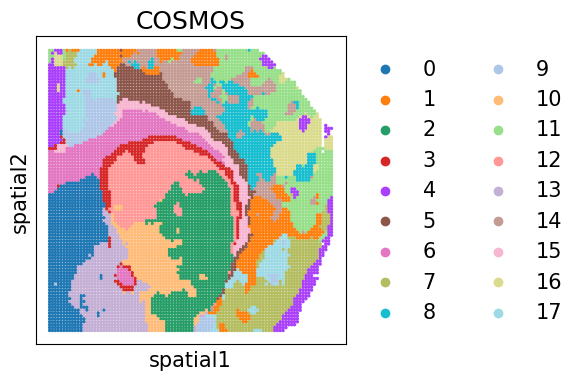

In [10]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='COSMOS',size=25,ax=ax)

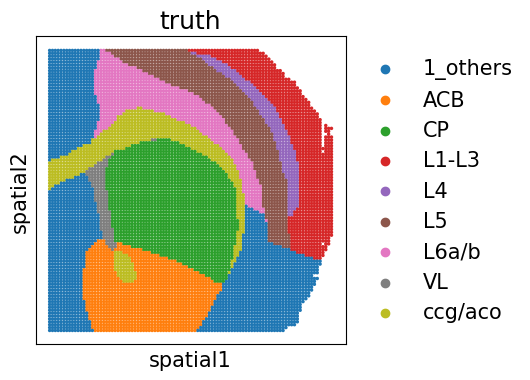

In [11]:
adata4=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset7_Mouse_Brain_ATAC/3d-OT.h5ad')
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata4,basis='spatial',color='truth',size=25,ax=ax)

In [12]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata4.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['COSMOS'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.3098240627176628
NMI: 0.538021911792341
AMI: 0.5365852512318452
FMI: 0.4089910441537301
V-Measure: 0.538021911792341
Homogeneity: 0.6480327901303414


In [13]:
adata_omics1.write_h5ad('/home/dbj/SpaLP/gittest/SpatialGlue/COSMOS_ATAC.h5ad',compression='gzip')